# Exercise 2: Penguin regression with PyTorch

<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png" width="750" />


Artwork by @allison_horst

In this exercise, we will again use the [``palmerpenguins``](https://github.com/mcnakhaee/palmerpenguins) data to continue our exploration of PyTorch.

We will use the same dataset object as before, but this time we'll take a look at a regression problem: predicting the mass of a penguin given other physical features.

### Task 1: look at the data
In the following code block, we import the ``load_penguins`` function from the ``palmerpenguins`` package.

- Load the penguin data as you did before.
- This time, consider which features we might like to use to predict a penguin's mass.

In [1]:
from palmerpenguins import load_penguins

data = load_penguins()

# Note: ``pd.DataFrame.describe`` is a useful function for giving an overview
# of what a ``pd.DataFrame`` contains.
print(data.describe())

print(data.keys())

       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
count      342.000000     342.000000         342.000000   342.000000   
mean        43.921930      17.151170         200.915205  4201.754386   
std          5.459584       1.974793          14.061714   801.954536   
min         32.100000      13.100000         172.000000  2700.000000   
25%         39.225000      15.600000         190.000000  3550.000000   
50%         44.450000      17.300000         197.000000  4050.000000   
75%         48.500000      18.700000         213.000000  4750.000000   
max         59.600000      21.500000         231.000000  6300.000000   

              year  
count   344.000000  
mean   2008.029070  
std       0.818356  
min    2007.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2009.000000  
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')


Let's now discuss the features we will use to classify the penguins' species, and populate the following list together:

#### Let's use:

- ``"species"``
    - Perhaps the most relevant aspect from which to estimate mass.
- ``"sex"``
    - Biologically relevant.
- ``"bill_length_mm"``
    - Biologically relevant.
- ``"bill_depth_mm"``
    - Biologically relevant.
- ``flipper_length_mm``
    - Biologically relevant.

#### Let's reject
- ``"island"``
    - While island could be predictive if dominated by a particular species it would be acting as a proxy and we have already included species as an input feature. 
- ``"year"``
    - This feature could also be important: then behaviour of certain species may be changing in response to time-dependent environmental factors such as melting ice. It does however seem like the least biologically-relevant feature, and the most likely source of bias, so we reject it.

### Task 2: creating a ``torch.utils.data.Dataset``

As before, we need to create PyTorch ``Dataset`` objects to supply data to our neural network.  
Since we have already created and explored the ``PenguinDataset`` class there is nothing else to do here.

### Task 3: Obtaining training and validation datasets.

- Instantiate the penguin dataloader.
  - Make sure you supply the correct column titles for the features and the targets.
  - Remember, the target is now mass, not the species!
- Iterate over the dataset
    - Hint:
        ```python
        for features, targets in dataset:
            # print the features and targets here
        ```

In [2]:
from ml_workshop import PenguinDataset

features = [
    "sex",
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
]

data_set = PenguinDataset(
    input_keys=features,
    target_keys=["body_mass_g"],
    train=True,
)

for _, (input_feats, target) in zip(range(20), data_set):
    print(input_feats, target)

(0.0, 42.9, 13.1, 215.0) (5000.0,)
(0.0, 46.1, 13.2, 211.0) (4500.0,)
(0.0, 44.9, 13.3, 213.0) (5100.0,)
(0.0, 43.3, 13.4, 209.0) (4400.0,)
(0.0, 42.0, 13.5, 210.0) (4150.0,)
(0.0, 46.5, 13.5, 210.0) (4550.0,)
(0.0, 44.0, 13.6, 208.0) (4350.0,)
(0.0, 40.9, 13.7, 214.0) (4650.0,)
(0.0, 42.6, 13.7, 213.0) (4950.0,)
(0.0, 42.7, 13.7, 208.0) (3950.0,)
(0.0, 45.3, 13.7, 210.0) (4300.0,)
(0.0, 47.2, 13.7, 214.0) (4925.0,)
(0.0, 45.2, 13.8, 215.0) (4750.0,)
(0.0, 43.6, 13.9, 217.0) (4900.0,)
(0.0, 43.8, 13.9, 208.0) (4300.0,)
(0.0, 45.5, 13.9, 210.0) (4200.0,)
(0.0, 45.7, 13.9, 214.0) (4400.0,)
(0.0, 43.3, 14.0, 208.0) (4575.0,)
(0.0, 47.5, 14.0, 212.0) (4875.0,)
(0.0, 46.2, 14.1, 217.0) (4375.0,)


### Task 4: Applying transforms to the data

As in the previous exercise, the raw inputs and targets need transforming to ``torch.Tensor``s before they can be passed to a neural network.  
We will again use ``torchvision.transforms.Compose`` to take a list of callable objects and apply them to the incoming data.

Because the raw units of mass are in grams, the numbers are quite large. This can encumber the model's predictive power. A sensible way to address this is to normalise targets using statistics from the training set. The most common form of normalisation is to subtract the mean and divide by the standard deviation (of the training set). However here, for the sake of simplicity, we will just scale the mass by dividing by the mean of the training set.

Note that this means that the model will now be trained to predict masses as fractions of the training mean.

We grab the mean of the training split in the following cell.

In [3]:
train_set = PenguinDataset(features, ["body_mass_g"], train=True)

training_mean = train_set.split.body_mass_g.mean()

Now we create our real training and validation set, and supply transforms as before.

In [4]:
from torch import tensor, float32, eye
from torchvision.transforms import Compose


# Apply the transforms we need to the PenguinDataset to get out inputs
# targets as Tensors.


def get_input_transforms() -> Compose:
    """Return transforms which map from raw inputs to tensors.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[float, ...]``) to a ``torch.Tensor``.

    """
    return Compose([lambda x: tensor(x, dtype=float32)])


def get_target_tfms() -> Compose:
    """Return transforms which map from the raw targets to tensors.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of target features (``Tuple[str]``) to a ``torch.Tensor``.

    Notes
    -----
    Note the rescaling by dividing out the training mean.

    """
    return Compose([lambda x: tensor(x, dtype=float32) / training_mean])


train_set = PenguinDataset(
    input_keys=features,
    target_keys=["body_mass_g"],
    train=True,
    x_tfms=get_input_transforms(),
    y_tfms=get_target_tfms(),
)


valid_set = PenguinDataset(
    input_keys=features,
    target_keys=["body_mass_g"],
    train=False,
    x_tfms=get_input_transforms(),
    y_tfms=get_target_tfms(),
)


for _, (input_feats, target) in zip(range(5), train_set):
    print(input_feats, target)

tensor([  0.0000,  42.9000,  13.1000, 215.0000]) tensor([1.1856])
tensor([  0.0000,  46.1000,  13.2000, 211.0000]) tensor([1.0670])
tensor([  0.0000,  44.9000,  13.3000, 213.0000]) tensor([1.2093])
tensor([  0.0000,  43.3000,  13.4000, 209.0000]) tensor([1.0433])
tensor([  0.0000,  42.0000,  13.5000, 210.0000]) tensor([0.9840])


### Task 5: Creating ``DataLoaders``—Again!

As before, we wrap our ``Dataset``s in ``DataLoader`` before we proceed.

In [5]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([16, 4]) torch.Size([16, 1])
torch.Size([16, 4]) torch.Size([16, 1])
torch.Size([16, 4]) torch.Size([16, 1])
torch.Size([12, 4]) torch.Size([12, 1])


### Task 6: Creating a neural network in PyTorch

Previously we created our neural network from scratch, but doing this every time we need to solve a new problem is cumbersome.  
Many projects working with the ICCS have codes where the numbers of layers, layer sizes, and other parts of the models are hard-coded from scratch every time!

The result is ungainly, non-general, and heavily-duplicated code. Here, we are going to shamelessly punt Jim Denholm's Python repo, [``TorchTools``](https://github.com/jdenholm/TorchTools), which contains generalisations of many commonly-used PyTorch tools, to save save us some time.

Here, we can use the ``FCNet`` model, whose documentation lives [here](https://jdenholm.github.io/TorchTools/models.html). This model is a fully-connected neural network with various options for dropout, batch normalisation, and easily-modifiable layers.

#### A brief sidebar
Note: the repo is pip-installable with
```bash
pip install git+https://github.com/jdenholm/TorchTools.git
```
but has already been installed for you in the requirements of this workshop package.

It is useful to know you can install Python packages from GitHub using pip. To install specific versions you can use:
```bash
pip install git+https://github.com/jdenholm/TorchTools.git@v0.1.0
```
(The famous [segment anything model](https://github.com/facebookresearch/segment-anything) (SAM) published by Facebook Research was released in this way.)

One might argue that this is a much better way of making one-off codes available, for example academic codes which might accompany papers, rather than using the global communal package index PyPI.

##### Back to work: let's instantiate the model.

In [6]:
from torch_tools import FCNet

model = FCNet(
    in_feats=4,
    out_feats=1,
    hidden_sizes=(16, 8, 4),
    input_bnorm=True,
    input_dropout=0.1,
    hidden_dropout=0.1,
    hidden_bnorm=True,
)
print(model)

FCNet(
  (0): InputBlock(
    (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (1): DenseBlock(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (4): DenseBlock(
    (0): Linear(in_features=4, out_features=1, bias=True)
  )
)


### Task 7: Selecting a loss function

The previous loss function we chose was appropriate for classification, but _not_ regression.  
Here we'll use the mean-squared-error loss, which is more appropriate for regression.

In [7]:
from torch.nn import MSELoss

loss_func = MSELoss()

### Task 8: Selecting an optimiser

``Adam`` is regarded as the king of optimisers: let's use it again, but this time specifying the learning rate.

[Adam docs](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [8]:
# Create an optimiser and give it the model's parameters.
from torch.optim import Adam

optimiser = Adam(model.parameters(), lr=1e-3)

### Task 9: Writing basic training and validation loops


As before, we will write the training loop together and you can then continue with the validation loop.


In [9]:
from typing import Dict
from torch.nn import Module
from torch import Tensor, no_grad
from numpy import mean, sqrt


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: MSELoss,
) -> Dict[str, float]:
    """Train ``model`` for once epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    train_loader : DataLoader
        Training dataloader.
    optimiser : Adam
        The optimiser.
    loss_func : MSELoss
        Mean squared error loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    Notes
    -----
    - The ``model.train()`` is very important:
        - it turns on the dropout layers.
        - it tells the batch norm layers to use the incoming statistics, and
          let them contribute to their "memory".

    """
    model.train()
    metrics: Dict[str, float] = {"loss": []}

    for batch, targets in train_loader:
        optimiser.zero_grad()

        preds = model(batch)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        metrics["loss"].append(loss.item())

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: MSELoss,
) -> Dict[str, float]:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    valid_loader : DataLoader
        Validation dataloader.
    loss_func : MSELoss
        Mean squared error loss function.

    Returns
    -------
    Dict[str, float]
        Metrics of interest.

    Notes
    -----
    - The ``model.eval()`` is also very important:
        - It turns off the dropout layers, which are likely to impair the
          validation performance and render it unrealistically poor.
        - It tells the batchnorm layers to _not_ use the batch's statistics,
          and to instead use the stats it has built up from the training set.
          The model should not "remember" anything from the validation set.
    - We also protect this function with ``torch.no_grad()``, because having
      gradients enable while validating is a pointless waste of resources—they
      are only needed for training.

    """
    model.eval()
    metrics: Dict[str, float] = {"loss": []}

    for batch, targets in valid_loader:
        preds = model(batch)

        loss = loss_func(preds, targets)

        metrics["loss"].append(loss.item())

    return {key: mean(val) for key, val in metrics.items()}

### Task 10: Training and extracting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turm them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.

In [10]:
from time import perf_counter
from pandas import DataFrame

epochs = 300
print_interval = 25

train_metrics, valid_metrics = [], []

for epoch in range(epochs):

    if epoch % print_interval == 0:
        if epoch != 0:
            print(f"Epoch {max(epoch - print_interval, 0)}-{epoch} time: {perf_counter() - tic:.6f} seconds")
        tic = perf_counter()


    train_metrics.append(train_one_epoch(model, train_loader, optimiser, loss_func))

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)

metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")

print(metrics)

Epoch 0-25 time: 4.234758 seconds
Epoch 25-50 time: 4.243387 seconds
Epoch 50-75 time: 4.252240 seconds
Epoch 75-100 time: 4.297547 seconds
Epoch 100-125 time: 4.254026 seconds
Epoch 125-150 time: 4.280980 seconds
Epoch 150-175 time: 4.243602 seconds
Epoch 175-200 time: 4.236814 seconds
Epoch 200-225 time: 4.238001 seconds
Epoch 225-250 time: 4.244598 seconds
Epoch 250-275 time: 4.229454 seconds


     loss_train  loss_valid
0      0.403945    0.258350
1      0.334612    0.286643
2      0.288723    0.248097
3      0.235608    0.204395
4      0.210375    0.182948
..          ...         ...
295    0.011671    0.008663
296    0.009973    0.008757
297    0.009214    0.008859
298    0.010670    0.008706
299    0.009724    0.008328

[300 rows x 2 columns]


### Task 11: Plotting metrics

- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.
- Does this allow us to interpret performance?

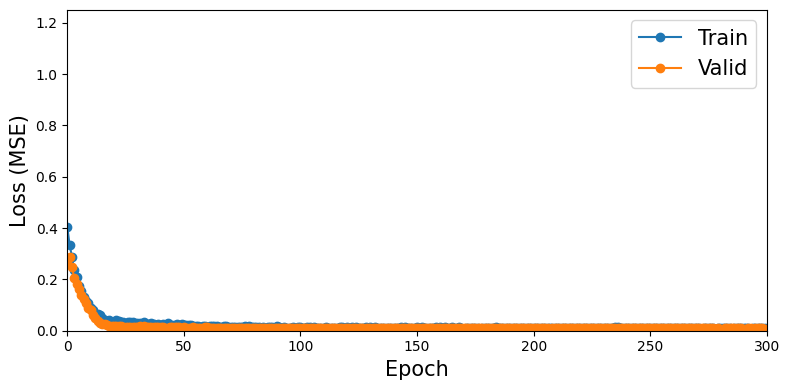

In [11]:
import matplotlib.pyplot as plt
from numpy import linspace


quantities = ["loss", "ratio"]
fig, axis = plt.subplots(1, 1, figsize=(8, 4))


axis.plot(metrics.loss_train, "-o", label="Train")
axis.plot(metrics.loss_valid, "-o", label="Valid")

# for axis in axes.ravel():
axis.legend(fontsize=15)
axis.set_ylim(bottom=0.0, top=1.25)
axis.set_xlim(left=0, right=epochs)
axis.set_xlabel("Epoch", fontsize=15)
axis.set_ylabel("Loss (MSE)", fontsize=15)

fig.tight_layout()

While this losses have decreased nicely, MSE isn't the most easily interpretable way to evaluate the model's performance. We could instead look at the ratio of the predictions to targets—and in particular, the distribution of this quantity.

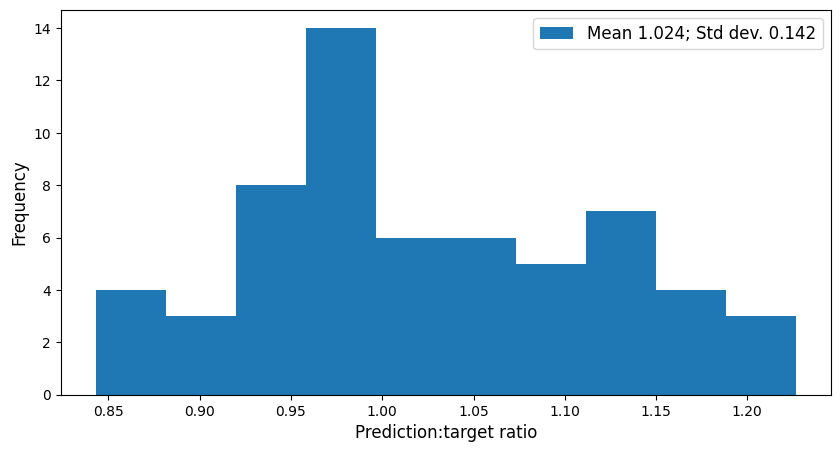

In [15]:
from torch import concat
from numpy import diff

model.eval()

predictions = []
targets = []

for batch, target in valid_loader:
    with no_grad():
        predictions.append(model(batch))
        targets.append(target)

predictions = concat(predictions).flatten()
targets = concat(targets).flatten()

ratios = predictions / targets

fig, axis = plt.subplots(1, 1, figsize=(10, 5))

axis.hist(ratios, bins=10, label=fr"Mean {ratios.mean():.3f}; Std dev. {predictions.std():.3f}",)
axis.set_xlabel("Prediction:target ratio", fontsize=12)
axis.set_ylabel("Frequency", fontsize=12)

axis.legend(fontsize=12)

axis.set_aspect(0.5 * diff(axis.get_xlim()) / diff(axis.get_ylim()))

plt.show()